  0%|          | 0/1 [00:00<?, ?it/s]

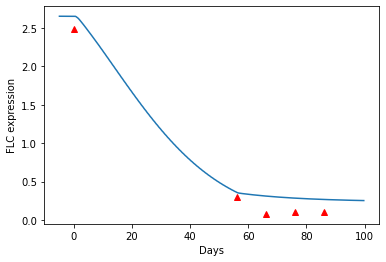

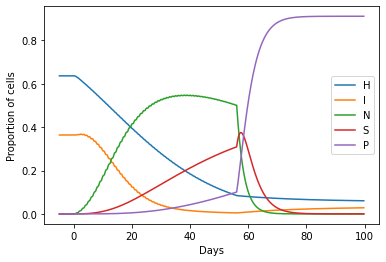

100%|██████████| 1/1 [00:06<00:00,  6.62s/it]

Value Errors:
[]
SSEmin:
0.057515967860677156 0 7 0 0.028


In [5]:
import numpy as np
import parameters as p
import runModel
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

df = pd.read_csv('test.csv')#change name of file if importing a different dataset
gen = df.loc[(df.Genotype == 'TEST_VARN') & (df.Experiment == 1)]#change Genotype name if using different genotype #experiment signifier added because the original dataset contained data from various experiments
gen = gen.drop_duplicates(subset=['Timepoint_Cold','Temperature','Timepoint'])
gen = gen.sort_values("Timepoint")
timetemp = (np.array([gen['Timepoint_Cold'],gen['Temperature'],gen['Timepoint']]))

daysCold_all= timetemp[0,1:]
temp_all= timetemp[1,1:]
days_all= timetemp[2,1:]
timeTC = set() #keeps unique values, not ordered

for i in range(len(daysCold_all)):
        days=days_all[(daysCold_all==daysCold_all[i]) & (temp_all==temp_all[i])]
        temp=temp_all[i]
        daysCold=daysCold_all[i]
        timeTC.add((tuple(days), temp, daysCold))#adds the loop values to the set


FLC_all = []
COLFRIinit = df.loc[(df.Genotype == 'TEST_CF') & (df.Timepoint == 0) & (df.Timepoint_Cold == 0) & (df.Experiment == 1)] #The genotype name used should import initial Col FRI data from the used dataset
CFinit = np.array(COLFRIinit.FLC)
df = df.loc[(df.Genotype == 'TEST_VARN') & (df.Experiment == 1)] #change Genotype name if using different genotype
df.FLC = df.FLC / np.mean(CFinit)
VARNin=df.loc[(df.Genotype == 'TEST_VARN') & (df.Timepoint == 0) & (df.Timepoint_Cold == 0) & (df.Experiment == 1)] #change Genotype name if using different genotype
VARNin_flc=np.array(VARNin.FLC)
VARNin_TT=np.array(VARNin.Timepoint)


n0i = [0]#Col FRI = 0.2
pf = np.arange(6, 8, 0.1)#Col FRI= 2.77, Var NIL = 7
pr2 = np.logspace(-3, 0, num= 10, base=10)#Col FRI = 0, Var NIL = 0.001
pr1 = np.logspace(-2, 0, num=10, base=10)#Col FRI = 0.05, Var NIL = 0.028
SSElist = []
n0ilist = []
pflist = []
pr2list = []
pr1list = []
ValueErrors = []

for n in tqdm(range(len(n0i))):
        p.param[7] = n0i[n]
        for f in range(len(pf)):
                p.param[13] = pf[f]
                for h in range(len(pr2)):  
                        p.param[5] = pr2[h]
                        for l in range(len(pr1)):
                                try:
                                        p.param[4] = pr1[l]       
                                        SSE=0 #resetting SSE variable to 0 for the upcoming model run
                                        for entry in timeTC: 
                                                days=np.array(entry[0])
                                                temp=entry[1]
                                                daysCold=entry[2]

                                                tiTi=np.array([[-5,timetemp[0,0],timetemp[0,0]+0.01, daysCold, daysCold+0.01, 100],[22,timetemp[1,0],temp, temp, temp,22]])
                                                p.tiTi=tiTi
                                                TT=np.array([tiTi[0][0],0,*days, tiTi[0][-1]])
                                                VIN3,FLC,TT,y=runModel.run_model(p.param,p.tiTi,TT)
                                                FLC_all.append(FLC)
                                                FLCex_flc = []
                                                FLCex_TT = []
                                                for i in range(len(days)):
                                                        gen = df.loc[(df.Genotype == 'TEST_VARN') & (df.Timepoint == days[i]) & (df.Temperature == temp) & (df.Timepoint_Cold == daysCold) & (df.Experiment == 1)] #change Genotype name if using different genotype
                                                        FLC_ex = np.array(gen.FLC)
                                                        FLCex_flc.extend(list(FLC_ex))
                                                        sumsq = (FLC_ex - FLC[i+2])*(FLC_ex - FLC[i+2])
                                                        SSE = SSE + sumsq.sum()
                                                        FLCex_TT.extend([days[i]]*len(FLC_ex))
                                                                                                
                                                p.tiTi=np.array([[-5,-0.01,0,daysCold,daysCold+0.01,100],[22,22,temp,temp,22,22]]) 
                                                TT=np.arange(p.tiTi[0][0], p.tiTi[0][-1], 0.25)
                                                VIN3,FLC,TT,y=runModel.run_model(p.param,p.tiTi,TT)

                                                #Plot of FLC mRNA in the conditions specified as "entry" in "timeTC". For information on which condistions produced the plot: print(entry)       
                                                plt.plot(TT, FLC, VARNin_TT, VARNin_flc, "r^", FLCex_TT, FLCex_flc, 'r^')
                                                plt.ylabel('FLC expression')
                                                plt.xlabel('Days')
                                                plt.show()
                                                #Plot of proportion of cells in states of silencing
                                                plt.plot(TT,y[:,3:8])
                                                plt.legend(['H','I','N','S','P'])
                                                plt.ylabel('Proportion of cells')
                                                plt.xlabel('Days')
                                                plt.show() 

                                        gen = df.loc[(df.Genotype == 'TEST_VARN') & (df.Timepoint == 0) & (df.Timepoint_Cold == 0) & (df.Experiment == 1)] #change Genotype name if using different genotype
                                        FLC_exi = np.array(gen.FLC)

                                        sumsq = (FLC_exi - FLC[1])*(FLC_exi - FLC[1])
                                        SSE = SSE + sumsq.sum()
                                        SSElist.append(SSE)
                                        pflist.append(pf[f])
                                        pr1list.append(pr1[l])
                                        pr2list.append(pr2[h])
                                        n0ilist.append(n0i[n])
                                        SSEarray = (SSElist, n0ilist, pflist, pr2list, pr1list)
                                        np.savetxt("SSE_values.csv",SSEarray,delimiter=",")
                                except ValueError:
                                         ValueErrors.append([n0i[n], pf[f], pr2[h], pr1[l]]) #Appends all conditions where an error occured into a list
                
SSEmin=min(SSEarray[0])
print("Value Errors:")
print(ValueErrors)

#this loop finds the minimin SSE and the "optimal fit" parameter values associated with it.
for i in range(len(SSEarray[0])):
        if SSEarray[0][i] == SSEmin:
                print('SSEmin:')
                print(SSEarray[0][i], SSEarray[1][i], SSEarray[2][i], SSEarray[3][i], SSEarray[4][i])

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
df = pd.read_csv('log10(SSE_values).csv') #SSE values output from above script. Log10 values of SSE calculated in Excel.
sse1 = df.loc[(df.n0i == 0) & (df.pr2 == 0.001)]
sse2 = df.loc[(df.n0i == 0) & (df.pr2 == 0.01)]
sse3 = df.loc[(df.n0i == 0) & (df.pr2 == 0.1)]
sse4 = df.loc[(df.n0i == 0) & (df.pr2 == 1)]
ssearray1 = np.array([sse1.pf, sse1.pr1])
ssearray2 = np.array([sse2.pf, sse2.pr1])
ssearray3 = np.array([sse3.pf, sse3.pr1])
ssearray4 = np.array([sse4.pf, sse4.pr1])
threeval1 = sse1[["logSSE","pf","pr1"]]
threeval2 = sse2[["logSSE","pf","pr1"]]
threeval3 = sse3[["logSSE","pf","pr1"]]
threeval4 = sse4[["logSSE","pf","pr1"]]
pivoted1 = threeval1.pivot("pf","pr1","logSSE")
pivoted2 = threeval2.pivot("pf","pr1","logSSE")
pivoted3 = threeval3.pivot("pf","pr1","logSSE")
pivoted4 = threeval4.pivot("pf","pr1","logSSE")
fig, ax = plt.subplots(figsize = (25,5), ncols=4)
sns.heatmap(pivoted1, vmin = 0.6, vmax = 1.5, cbar = False, ax=ax[0])
sns.heatmap(pivoted2, vmin = 0.6, vmax =1.5, cbar = False, ax=ax[1])
sns.heatmap(pivoted3, vmin = 0.6, vmax = 1.5, cbar = False, ax=ax[2])
sns.heatmap(pivoted4, vmin = 0.6, vmax =1.5, cbar = True, ax=ax[3])

plt.show()